In [1]:
import numpy as np
import pandas as pd
from docplex.mp.model import Model
import os
import dimod
from dwave.system import LeapHybridSampler

In [2]:
# --- Generate couplings ---
def generate_J(N, seed=None):
    # Create directory if it doesn't exist
    os.makedirs('generated_data', exist_ok=True)
    
    if seed is not None:
        np.random.seed(seed)
    std = 1.0 / np.sqrt(N)
    data = [(i, j, np.random.normal(0, std)) for i in range(N) for j in range(i+1, N)]
    df = pd.DataFrame(data, columns=['i','j','Jij'])
    
    if seed is not None:
        filepath = f'generated_data/Jij_N{N}_seed{seed}.csv'
        df.to_csv(filepath, index=False)
        print(f"Saved couplings for N={N} to {filepath}")
    else:
        filepath = f'generated_data/Jij_N{N}.csv'
        df.to_csv(filepath, index=False)
        print(f"Saved couplings for N={N} to {filepath}")

# --- Load couplings ---
def load_J(N, seed=None):
    filename = f'generated_data/Jij_N{N}_seed{seed}.csv' if seed is not None else f'generated_data/Jij_N{N}.csv'
    df = pd.read_csv(filename)
    N = max(df['i'].max(), df['j'].max()) + 1
    return [(int(i), int(j), float(Jij)) for i,j,Jij in df.values], N

In [3]:
def solve_SK(rows, N, seed, time_limit=None):
    from docplex.mp.model import Model
    import pandas as pd
    import os
    
    # Create directory if it doesn't exist
    os.makedirs('cplex_solutions', exist_ok=True)

    mdl = Model('SK_Ising')
    x = mdl.binary_var_list(N, name='x')

    expr = 0
    for i, j, Jij in rows:
        expr += -4*Jij * x[i]*x[j] + 2*Jij*(x[i] + x[j]) - Jij

    mdl.minimize(expr)

    if time_limit is not None:
        mdl.parameters.timelimit = float(time_limit)

    sol = mdl.solve(log_output=False)

    if not sol:
        print("No solution found.")
        return

    x_sol = [int(sol.get_value(var)) for var in x]
    S = [2*xi - 1 for xi in x_sol]
    E = sum(-Jij * S[i]*S[j] for i,j,Jij in rows)

    # Print solution status and gap
    status = mdl.solve_details.status
    mip_gap = mdl.solve_details.mip_relative_gap

    print(f"N = {N}\nEnergy = {E}")
    print(f"Status: {status}")
    if mip_gap is not None:
        print(f"MIP gap: {mip_gap:.4f}")
    print(f"First spins: {S}")

    filepath = f'cplex_solutions/solution_N{N}_seed{seed}.csv'
    pd.DataFrame({'i': range(N), 'Energy_cplex': E, 'x': x_sol, 'S': S}).to_csv(filepath, index=False)
    print(f"Saved solution to {filepath}")
    return E, S

In [4]:
N = 50  # choose system size
seed = 42 # choose seed or set to None
generate_J(N, seed=seed)
rows, N = load_J(N, seed=seed)
energy_cplex, S_cplex = solve_SK(rows, N, seed=seed, time_limit=300)

Saved couplings for N=50 to generated_data/Jij_N50_seed42.csv
N = 50
Energy = -36.0445281812347
Status: integer optimal, tolerance
MIP gap: 0.0001
First spins: [-1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1]
Saved solution to cplex_solutions/solution_N50_seed42.csv


In [5]:
# --- Build and solve D-Wave BQM model ---
def solve_SK_dwave(rows, N, seed=None, time_limit=30):
    # Create directory if it doesn't exist
    os.makedirs('dwave_solutions', exist_ok=True)
    # Build Binary Quadratic Model (BQM) in SPIN variables
    h = {i: 0.0 for i in range(N)} # no onsite field
    J = {(i, j): -Jij for i, j, Jij in rows} # match SK Hamiltonian: H = -sum Jij S_i S_j


    bqm = dimod.BinaryQuadraticModel(h, J, dimod.SPIN)


    sampler = LeapHybridSampler()
    sampleset = sampler.sample(bqm, time_limit=time_limit)


    result = sampleset.first.sample
    S = [result[i] for i in range(N)]
    energy = min(sampleset.record.energy)


    print(f"N = {N}\nEnergy = {energy}") 
    print(f"First spins: {S}")

    filepath = f'dwave_solutions/solution_N{N}_seed{seed}.csv'

    pd.DataFrame({'i': range(N), 'Energy_dwave': energy, 'S': S}).to_csv(filepath, index=False)

    print(f"Saved solution to {filepath}")
    return energy, S

In [6]:
energy_dwave, S_dwave = solve_SK_dwave(rows, N, seed=seed, time_limit=30)

N = 50
Energy = -36.04452818123466
First spins: [1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1]
Saved solution to dwave_solutions/solution_N50_seed42.csv


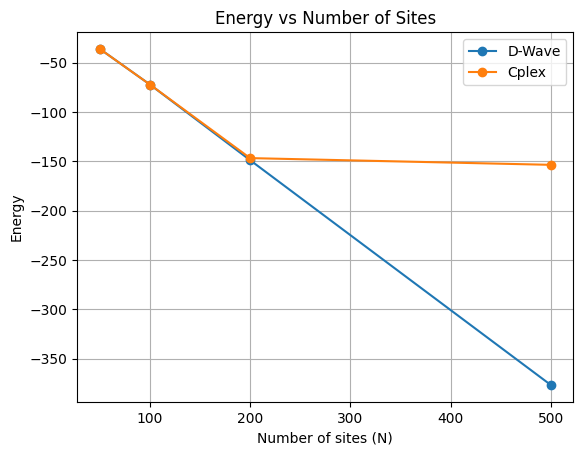

In [7]:
N = [50, 100, 200, 500]
energy_dwave_expt =[-36.0445281812347, -72.13455390916793, -148.77034247120758, -376.47827708411097]
energy_cplex_expt = [-36.0445281812347, -72.13455390916799, -146.67336395363563, -153.48239045129037]
import matplotlib.pyplot as plt

plt.plot(N, energy_dwave_expt, label='D-Wave', marker='o')
plt.plot(N, energy_cplex_expt, label='Cplex', marker='o')
plt.xlabel('Number of sites (N)')
plt.ylabel('Energy')
plt.title('Energy vs Number of Sites')
plt.legend()
plt.grid()
plt.show()

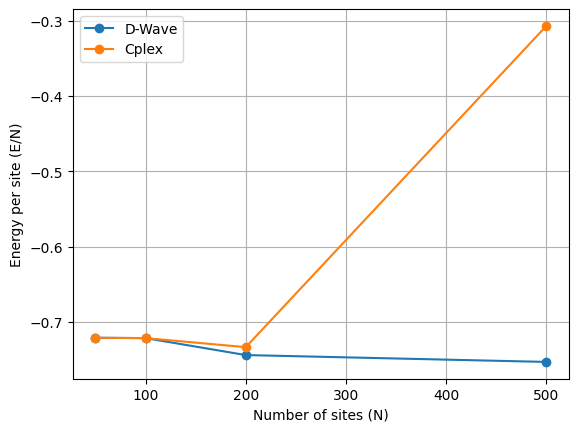

In [ ]:
N = [50, 100, 200, 500]
energy_dwave_expt =[-36.0445281812347, -72.13455390916793, -148.77034247120758, -376.47827708411097]
energy_cplex_expt = [-36.0445281812347, -72.13455390916799, -146.67336395363563, -153.48239045129037]
import matplotlib.pyplot as plt

plt.plot(N, np.array(energy_dwave_expt)/np.array(N), label='D-Wave', marker='o')
plt.plot(N, np.array(energy_cplex_expt)/np.array(N), label='Cplex', marker='o')
plt.xlabel('Number of sites (N)')
plt.ylabel('Energy per site (E/N)')
# plt.title('Energy per site vs Number of Sites')
plt.legend()
plt.grid()
plt.show()
# save plot 

In [1]:
-36.0445281812347/50

-0.7208905636246941

In [3]:
import numpy as np
np.array([1,2,3,4])/np.array([1,2,3,4])

array([1., 1., 1., 1.])

In [5]:
-376.47827708411097/500

-0.7529565541682219

In [7]:
N = [50, 100, 200, 500]
energy_dwave_expt =[-36.0445281812347, -72.13455390916793, -148.77034247120758, -376.47827708411097]
energy_cplex_expt = [-36.0445281812347, -72.13455390916799, -146.67336395363563, -153.48239045129037]
np.array(energy_dwave_expt)/np.array(N)

array([-0.72089056, -0.72134554, -0.74385171, -0.75295655])

In [8]:
np.array(energy_cplex_expt)/np.array(N)

array([-0.72089056, -0.72134554, -0.73336682, -0.30696478])